In [73]:
import pandas as pd

data = [
    {
        'exp_date': {'Dinner1_Trevor': '04/20/23'},
        'lines': [
            ('trevor', 'steak', 45),
            ('arthur', 'steak', 32),
            ('tommy', 'crab', 55),
            ('trevor/arthur/tommy', 'fries', 12)
        ],
        'tax_tip': (12.89, 44)
    },
    {
        'exp_date': {'Dinner2_Nick': '04/21/23'},
        'lines': [
            ('Nick', 'pasta', 29.95),
            ('tommy', 'chicken', 32),
            ('trevor', 'salmon', 42),
            ('nick/tommy/trevor', 'pitchers', 85)
        ],
        'tax_tip': (28.38, 64)
    }
]

def intake(exp_date, lines, tax_tip):
    items = {}
    names = []
    for line in lines:
        name, item, price = line
        name = name.capitalize()
        item = item.capitalize()
        price = float(price)
        if "/" in name:
            split = name.split("/")
            price = float(price/len(split))
            for name in split:
                name = name.capitalize()
                if item not in items:
                    items[item] = {name: price}
                else:
                    items[item][name] = price
                if name not in names:
                    names.append(name)
        else:
            if item not in items:
                items[item] = {name: price}
            else:
                items[item][name] = price
            if name not in names:
                names.append(name)

    tax, tip = tax_tip

    return exp_date, items, names, tax, tip

def receipt_to_df():
    dfs = {}
    df_list = []
    df_name_date = {}  # Keep track of the date for each DataFrame

    for receipt_data in data:
        try:
            exp_date, items, names, tax, tip = intake(**receipt_data)

            # Subtotal = creating list for all prices
            keys = items.keys()
            l2 = []
            for v in keys:
                l1 = items[v].values()
                for v in l1:
                    l2.append(float(v))
            subtotal = sum(l2)

            # Adj rates
            tax_rate = (tax / subtotal)
            tip_rate = (tip / subtotal)

            # Personal subtotal dict
            nested = items.values()
            per_sub = {}
            for d in nested:
                for k, v in d.items():
                    per_dict = {k:v}
                    for k, v in per_dict.items():
                        if k in per_sub:
                            per_sub[k] += float(v)
                        else:
                            per_sub[k] = float(v)

            # Personal Adj tax and tips
            per_tax = {}
            for k in per_sub:
                per_tax[k] = (per_sub[k] * tax_rate)
            per_tip = {}
            for k in per_sub:
                per_tip[k] = (per_sub[k] * tip_rate)

            # nested list comprehension to sort the items dictionary keys based on the names list order
            # for names dict is nested in items dict
            sorted_items = {item: {name: items[item].get(name, 0) for name in names} \
                            for item in items}


            # Create dataframe using sorted_items
            df = pd.DataFrame.from_dict(sorted_items, orient="index").fillna(0)

            # First column to "Items"
            df.index.name = "Items"

            # Rename columns to names
            df.columns = names

            # Add Personal subtotal and Adj Tax/Tip rows
            df.loc["Subtotal"] = {name: per_sub[name] for name in names}
            df.loc["Adj Tax"] = {name: per_tax[name] for name in names}
            df.loc["Adj Tip"] = {name: per_tip[name] for name in names}

            # Add Total column
            df['Total'] = df.iloc[(df.index.get_loc('Subtotal')):, 0:].applymap(float)\
            .sum(axis=1)

            # Add Total Row
            df.loc['Total'] = df.iloc[(df.index.get_loc('Subtotal')):, 0:]\
            .applymap(float).sum(axis=0)

            # Move the index name to a new row
            df = df.reset_index().rename_axis(None, axis=1)
    
            for key, value in exp_date.items():
                df_name = key
                date = value

           # Save the DataFrame with csv extension
            df.to_csv(f'{df_name}.csv', index=False)

            dfs[df_name] = df
            df_name_date[df_name] = date  # Store the date
            df_list.append(df)
        except Exception as e:
            print("Invalid input. Please try again.")
            continue

    result = []
    for i, (df_name, df) in enumerate(dfs.items()):
        melted_df = pd.melt(df, id_vars=['Items'], var_name='names', value_name='price')
        filtered_melt = melted_df[melted_df['Items'] == 'Total']
        df_names = list(filtered_melt['names'])
        df_prices = list(filtered_melt['price'])

        master_df = pd.DataFrame(columns = ['Date', 'Expense'] + df_names) # Creates master DataFrame column headings
        master_df.loc[0] = [df_name_date[df_name], df_name] + df_prices  # Fills columns with data from melt

        
        result.append(master_df)
        master = pd.concat(result, ignore_index=True)
        total_col = master.pop('Total')  # Remove the Total column
        master['Total'] = total_col  # Add the removed column back which puts it to the end


    return (df_list, dfs, master, df_name_date)

df_list, dfs, master, df_name_date = receipt_to_df()

for i in df_list:
    display(i)

display(master)

cols = list(master.columns.values)
cols.remove('Date')
cols.remove('Expense')
cols.remove('Total')
names = cols;
print(names)

,Items,Trevor,Arthur,Tommy,Total
0,Steak,45.000000,32.0000,0.000000,NaN
1,Crab,0.000000,0.0000,55.000000,NaN
2,Fries,4.000000,4.0000,4.000000,NaN
3,Subtotal,49.000000,36.0000,59.000000,144.00
4,Adj Tax,4.386181,3.2225,5.281319,12.89
5,Adj Tip,14.972222,11.0000,18.027778,44.00
6,Total,68.358403,50.2225,82.309097,200.89


,Items,Nick,Tommy,Trevor,Total
0,Pasta,29.950000,0.000000,0.000000,NaN
1,Chicken,0.000000,32.000000,0.000000,NaN
2,Salmon,0.000000,0.000000,42.000000,NaN
3,Pitchers,28.333333,28.333333,28.333333,NaN
4,Subtotal,58.283333,60.333333,70.333333,188.95
5,Adj Tax,8.754067,9.061974,10.563959,28.38
6,Adj Tip,19.741378,20.435741,23.822881,64.00
7,Total,86.778778,89.831049,104.720173,281.33


,Date,Expense,Trevor,Arthur,Tommy,Nick,Total
0,04/20/23,Dinner1_Trevor,68.358403,50.2225,82.309097,NaN,200.89
1,04/21/23,Dinner2_Nick,104.720173,NaN,89.831049,86.778778,281.33


['Trevor', 'Arthur', 'Tommy', 'Nick']


# Graphs

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Scatter plot showing everyones costs from the meals

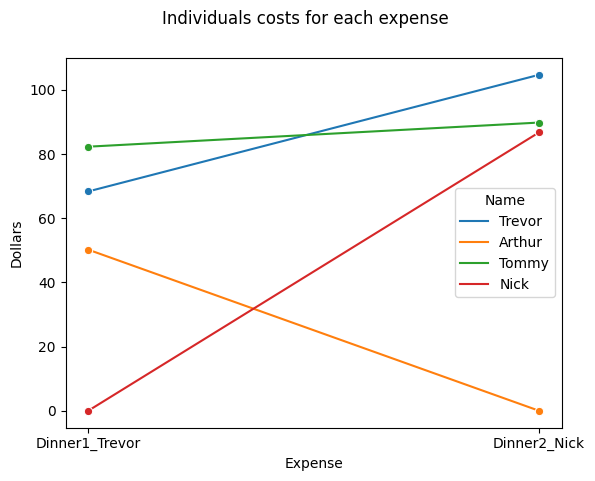

In [137]:
def lineplot_costs(master):
    df = master.drop(['Date', 'Total'], axis=1)
    names = list(df.columns.values)
    names.remove('Expense')
    data = []
    for i in range(0, df.shape[0]):
        for name in names: 
            data.append([df.iloc[i]['Expense'], df.iloc[i][name], name])
    scatter_df = pd.DataFrame(data, columns=['Expense', 'Dollars', 'Name'])
    expenses = scatter_df['Expense'].unique()
    for count, value in enumerate(expenses): 
        scatter_df.loc[scatter_df['Expense'] == value, 'Expense'] = count
    scatter_df = scatter_df.fillna(0)

    fig, ax = plt.subplots()
    fig.suptitle('Individuals costs for each expense')
    ax.xaxis.set_ticks([i for i in range(len(expenses))])
    graph = sns.lineplot(data=scatter_df, x='Expense', y='Dollars', hue="Name", marker='o')
    graph.set(xticklabels=expenses)
    #graph.tick_params(bottom=False)
    plt.show()

lineplot_costs(master)

### Barplot showing the total cost from each expense

<AxesSubplot:xlabel='Expense', ylabel='Total'>

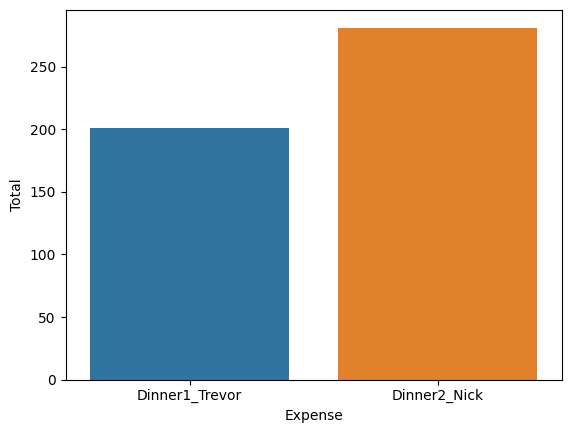

In [60]:
sns.barplot(data=master, x="Expense", y="Total")

## Show everybodys percentage of the total money spent

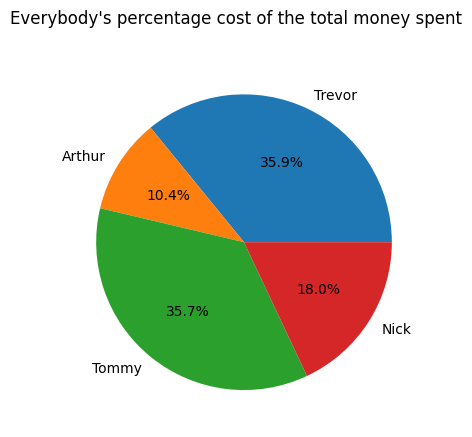

In [35]:
def percentage_of_total_bill(master):
    names = master.drop(columns=['Date', 'Expense', 'Total'])
    totals = names.sum()
    fig, ax = plt.subplots()
    fig.suptitle('Everybody\'s percentage cost of the total money spent')
    ax.pie(names.sum(), labels=totals.index, autopct='%1.1f%%')
    plt.show()

percentage_of_total_bill(master)